In [5]:
!pip install catboost lightgbm -qq

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from sqlite3 import connect
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # Ensure these are imported
import numpy as np
import pandas as pd # Ensure pandas is imported if not already at the top
from sklearn.preprocessing import PowerTransformer

In [7]:
path_od = "https://raw.githubusercontent.com/dataskillsboost/FinalProjectDA11/main/order_detail.csv"
path_pd = "https://raw.githubusercontent.com/dataskillsboost/FinalProjectDA11/main/payment_detail.csv"
path_cd = "https://raw.githubusercontent.com/dataskillsboost/FinalProjectDA11/main/customer_detail.csv"
path_sd = "https://raw.githubusercontent.com/dataskillsboost/FinalProjectDA11/main/sku_detail.csv"
df_od = pd.read_csv(path_od)
df_pd = pd.read_csv(path_pd)
df_cd = pd.read_csv(path_cd)
df_sd = pd.read_csv(path_sd)

In [8]:
df_od.head()

,id,customer_id,order_date,sku_id,price,qty_ordered,before_discount,discount_amount,after_discount,is_gross,is_valid,is_net,payment_id
0,ODR9939707760w,C713589L,2021-11-19,P858068,26100,200,5220000.0,2610000.00,2610000.00,1,1,0,5
1,ODR7448356649d,C551551L,2021-11-19,P886455,1971942,5,9859710.0,2464927.50,7394782.50,1,0,0,5
2,ODR4011281866z,C685596L,2021-11-25,P678648,7482000,1,7482000.0,2065344.62,5416655.38,1,0,0,4
3,ODR3378927994s,C830683L,2021-11-22,P540013,3593680,1,3593680.0,1455440.40,2138239.60,1,1,1,5
4,ODR4904430099k,C191766L,2021-11-21,P491032,4413220,1,4413220.0,1059172.80,3354047.20,1,1,1,4


In [9]:
df_pd.head()

,id,payment_method
0,1,cod
1,2,jazzvoucher
2,3,customercredit
3,4,Payaxis
4,5,jazzwallet


In [10]:
df_cd.head()

,id,registered_date
0,C996508L,2021-07-10
1,C180415L,2021-07-18
2,C535451L,2021-07-23
3,C177843L,2021-07-12
4,C951682L,2021-07-27


In [11]:
df_sd.head()

,id,sku_name,base_price,cogs,category
0,P798444,AT-FSM-35,57631.70,46052,Kids & Baby
1,P938347,AYS_Haier-18HNF,3931789.26,3499256,Appliances
2,P826364,Atalian _DV206A-Brown-41,324597.00,243426,Men Fashion
3,P467533,Darul_Sakoon_Food_Bundle,2870.42,2378,Superstore
4,P229955,HP_15AY-15-Ay072NIA-ci3,2265625.00,1631250,Computing


In [12]:
conn = connect(':memory:')
df_od.to_sql('order_detail',conn, index=False, if_exists='replace')
df_pd.to_sql('payment_detail', conn, index=False, if_exists='replace')
df_sd.to_sql('sku_detail', conn, index=False, if_exists='replace')
df_cd.to_sql('customer_detail', conn, index=False, if_exists='replace')

3998

In [13]:
df = pd.read_sql("""
SELECT
    order_detail.*,
    payment_detail.payment_method,
    sku_detail.sku_name,
    sku_detail.base_price,
    sku_detail.cogs,
    sku_detail.category,
    customer_detail.registered_date
FROM order_detail
LEFT JOIN payment_detail
    on payment_detail.id = order_detail.payment_id
LEFT JOIN sku_detail
    on sku_detail.id = order_detail.sku_id
LEFT JOIN customer_detail
    on customer_detail.id = order_detail.customer_id
""", conn)

df.head()

,id,customer_id,order_date,sku_id,price,qty_ordered,before_discount,discount_amount,after_discount,is_gross,is_valid,is_net,payment_id,payment_method,sku_name,base_price,cogs,category,registered_date
0,ODR9939707760w,C713589L,2021-11-19,P858068,26100,200,5220000.0,2610000.00,2610000.00,1,1,0,5,jazzwallet,RB_Dettol Germ Busting Kit-bf,26100.0,18270,Others,2021-07-07
1,ODR7448356649d,C551551L,2021-11-19,P886455,1971942,5,9859710.0,2464927.50,7394782.50,1,0,0,5,jazzwallet,PS4_Slim-500GB,1971942.0,1321182,Entertainment,2021-11-20
2,ODR4011281866z,C685596L,2021-11-25,P678648,7482000,1,7482000.0,2065344.62,5416655.38,1,0,0,4,Payaxis,Changhong Ruba 55 Inches UD55D6000i Ultra HD T...,7482000.0,5162580,Entertainment,2021-11-19
3,ODR3378927994s,C830683L,2021-11-22,P540013,3593680,1,3593680.0,1455440.40,2138239.60,1,1,1,5,jazzwallet,dawlance_Inverter 30,3593680.0,3054628,Appliances,2021-11-03
4,ODR4904430099k,C191766L,2021-11-21,P491032,4413220,1,4413220.0,1059172.80,3354047.20,1,1,1,4,Payaxis,Dawlance_Inverter-45 2.0 ton,4413220.0,3177472,Appliances,2021-07-05


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5884 entries, 0 to 5883
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5884 non-null   object 
 1   customer_id      5884 non-null   object 
 2   order_date       5884 non-null   object 
 3   sku_id           5884 non-null   object 
 4   price            5884 non-null   int64  
 5   qty_ordered      5884 non-null   int64  
 6   before_discount  5884 non-null   float64
 7   discount_amount  5884 non-null   float64
 8   after_discount   5884 non-null   float64
 9   is_gross         5884 non-null   int64  
 10  is_valid         5884 non-null   int64  
 11  is_net           5884 non-null   int64  
 12  payment_id       5884 non-null   int64  
 13  payment_method   5884 non-null   object 
 14  sku_name         5884 non-null   object 
 15  base_price       5884 non-null   float64
 16  cogs             5884 non-null   int64  
 17  category      

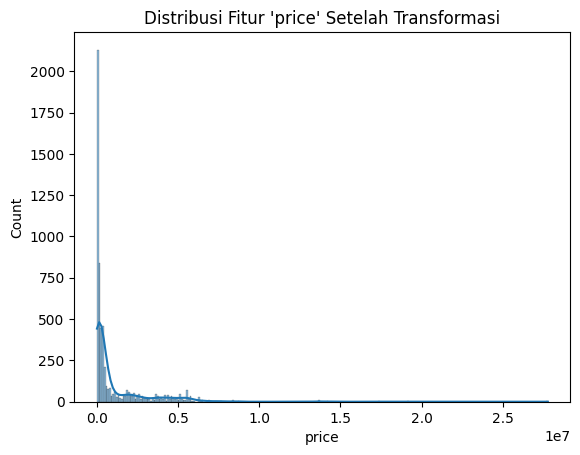

In [15]:
# Contoh untuk 1 fitur: price
sns.histplot(df['price'], kde=True)
plt.title("Distribusi Fitur 'price' Setelah Transformasi")
plt.show()

In [16]:
# --- Konversi tipe waktu
df['order_date'] = pd.to_datetime(df['order_date'])
df['registered_date'] = pd.to_datetime(df['registered_date'])

# --- Feature Engineering
df['discount_rate'] = df['discount_amount'] / df['before_discount']
df['margin'] = df['after_discount'] - df['cogs']
df['customer_age_days'] = (df['order_date'] - df['registered_date']).dt.days
df['optimal_price'] = df['cogs'] + df['margin'] * 1.10  # target prediksi baru
df['price_per_unit'] = df['after_discount'] / df['qty_ordered']
df['days_since_register'] = (df['order_date'] - df['registered_date']).dt.days

In [17]:
from sklearn.ensemble import IsolationForest

# 4. Outlier Detection dengan Isolation Forest
numerical_cols = ['price', 'qty_ordered', 'before_discount', 'discount_amount',
                  'after_discount', 'base_price', 'cogs', 'price_per_unit']

iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df[numerical_cols])
df['outlier'] = outliers
df = df[df['outlier'] == 1].drop(columns=['outlier'])

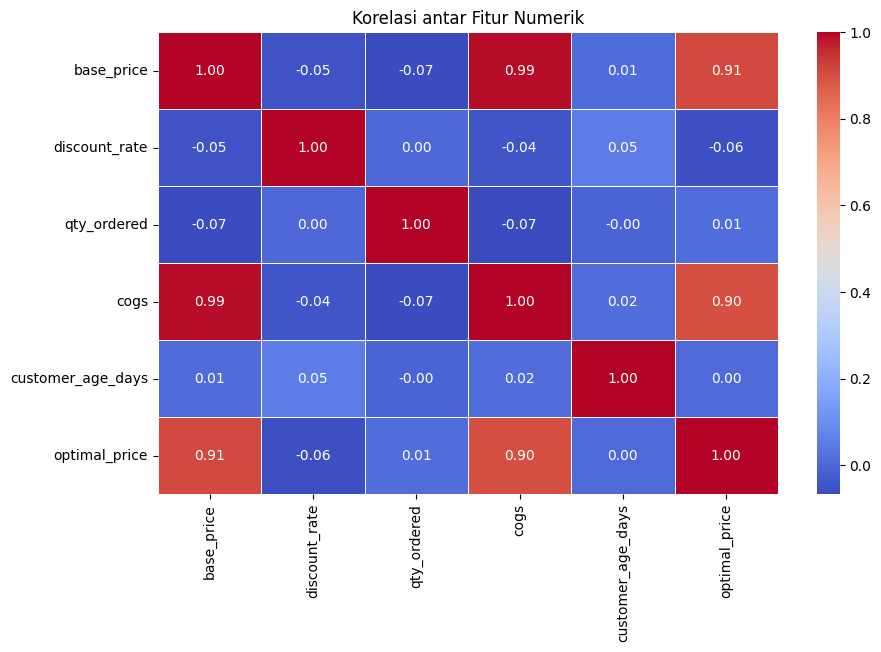

In [18]:
# --- Pilih subset data numerik untuk heatmap
numeric_cols = ['base_price', 'discount_rate', 'qty_ordered', 'cogs', 'customer_age_days', 'optimal_price']
corr_matrix = df[numeric_cols].corr()

# --- Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korelasi antar Fitur Numerik")
plt.show()

In [19]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

# 5. Perbaikan Skewness
skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index.tolist()

pt = PowerTransformer()
df[skewed_cols] = pt.fit_transform(df[skewed_cols])

In [20]:
df = df.dropna()

In [21]:
# Simpan kategori asli sebelum get_dummies
unique_categories = df['category'].unique().tolist()

# Lanjutkan dengan one-hot encoding
df = pd.get_dummies(df, columns=['category'], drop_first=True)

X = df.drop(columns=['after_discount', 'order_date', 'registered_date', 'sku_name',
                     'sku_id', 'customer_id', 'id'])
y = df['after_discount']

In [22]:
# Loop berdasarkan kategori asli (yang sudah disimpan sebelum get_dummies)
for category in unique_categories:
    print(f"\n📦 Kategori: {category}")

    # Tangani kasus kategori yang dummy-nya dihapus (karena drop_first=True)
    dummy_col = f'category_{category}'
    if dummy_col in df.columns:
        category_mask = df[dummy_col] == 1
    else:
        # Ini adalah kategori pertama yang di-drop → baris yang semua dummy kategori == 0
        dummy_category_cols = [col for col in df.columns if col.startswith('category_')]
        category_mask = ~df[dummy_category_cols].any(axis=1)  # semua dummy == 0

    # Subset dataframe berdasarkan kategori
    df_cat = df[category_mask].copy()

    # Skip jika kosong
    if df_cat.empty:
        print(f"⚠️ Tidak ada data untuk kategori {category}. Lewati.")
        continue

    # Pastikan kolom yang diperlukan ada
    features = ['base_price', 'discount_rate', 'qty_ordered', 'cogs', 'customer_age_days']
    target = 'optimal_price'

    if not all(col in df_cat.columns for col in features + [target]):
        missing = [col for col in features + [target] if col not in df_cat.columns]
        print(f"⚠️ Kolom hilang {missing} untuk kategori {category}. Lewati.")
        continue

    X = df_cat[features]
    y = df_cat[target]

    if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
        print(f"⚠️ Ditemukan NaN di kategori {category}. Lewati.")
        continue

    # Split dan scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_scaled = scaler.fit_transform(X)

    # Define models dictionary
    models = {
        'Ridge': Ridge(),
        'RandomForest': RandomForestRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'XGBoost': XGBRegressor()
    }

    results = [] # Initialize results list

    kf = KFold(n_splits=5, shuffle=True, random_state=42) # Define kf

    # Evaluasi model
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=kf)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        results.append({
            'category': category,
            'model': name,
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2_holdout': r2_score(y_test, y_pred),
            'CV_R2_mean': np.mean(cv_scores),
            'CV_R2_std': np.std(cv_scores)
        })

        print(f"🔸 {name}: MAE={mean_absolute_error(y_test, y_pred):.2f}, "
              f"RMSE={np.sqrt(mean_squared_error(y_test, y_pred)):.2f}, "
              f"R² Holdout={r2_score(y_test, y_pred):.2f}, "
              f"CV R²={np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")


📦 Kategori: Appliances
🔸 Ridge: MAE=549325.31, RMSE=756550.69, R² Holdout=0.82, CV R²=0.72 ± 0.10
🔸 RandomForest: MAE=116732.25, RMSE=268907.05, R² Holdout=0.98, CV R²=0.91 ± 0.11
🔸 GradientBoosting: MAE=148237.57, RMSE=340543.01, R² Holdout=0.96, CV R²=0.91 ± 0.10
🔸 XGBoost: MAE=111453.33, RMSE=236811.38, R² Holdout=0.98, CV R²=0.84 ± 0.16

📦 Kategori: Entertainment
🔸 Ridge: MAE=814532.98, RMSE=998760.39, R² Holdout=0.69, CV R²=0.63 ± 0.10
🔸 RandomForest: MAE=100105.25, RMSE=225082.66, R² Holdout=0.98, CV R²=0.90 ± 0.10
🔸 GradientBoosting: MAE=147899.50, RMSE=489516.94, R² Holdout=0.93, CV R²=0.90 ± 0.10
🔸 XGBoost: MAE=100536.47, RMSE=243995.30, R² Holdout=0.98, CV R²=0.94 ± 0.06

📦 Kategori: Computing
🔸 Ridge: MAE=1021462.01, RMSE=1281451.02, R² Holdout=0.80, CV R²=0.79 ± 0.01
🔸 RandomForest: MAE=129946.58, RMSE=354074.68, R² Holdout=0.98, CV R²=0.98 ± 0.02
🔸 GradientBoosting: MAE=93668.91, RMSE=210614.83, R² Holdout=0.99, CV R²=0.98 ± 0.01
🔸 XGBoost: MAE=120811.89, RMSE=303808.12, 

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import os
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from xgboost import XGBRegressor


# Dictionary model terbaik per kategori
best_models_dict = {
    'Appliances': GradientBoostingRegressor(),
    'Beauty & Grooming': XGBRegressor(),
    'Books': Ridge(),
    'Computing': GradientBoostingRegressor(),
    'Entertainment': Ridge(),
    'Health & Sports': Ridge(),
    'Home & Living': GradientBoostingRegressor(),
    'Kids & Baby': GradientBoostingRegressor(),
    'Men Fashion': Ridge(),
    'Mobiles & Tablets': RandomForestRegressor(),
    'Others': XGBRegressor(),
    'School & Education': GradientBoostingRegressor(),
    'Soghaat': GradientBoostingRegressor(),
    'Superstore': RandomForestRegressor(),
    'Women Fashion': GradientBoostingRegressor()
}

# Hyperparameter grids
param_grids = {
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

# Hasil akhir
boosted_results = []

# Loop berdasarkan best_models_dict
for category, base_model in best_models_dict.items():
    print(f"\n🚀 Boosting untuk kategori: {category}")

    # Nama kolom dummy dari kategori
    dummy_col = f"category_{category}"

    # Cek apakah kolom dummy ini ada di df
    if dummy_col in df.columns:
        df_cat = df[df[dummy_col] == True].copy()
    else:
        # Handle kategori pertama yang di-drop saat OHE
        category_cols = [col for col in df.columns if col.startswith('category_')]
        df_cat = df[~df[category_cols].any(axis=1)].copy()

    # Skip jika data kosong
    if df_cat.empty:
        print(f"⚠️ Data kosong untuk kategori: {category}, dilewati.")
        continue

    # Fitur dan target
    features = ['base_price', 'discount_rate', 'qty_ordered', 'cogs', 'customer_age_days']
    target = 'optimal_price'

    # Validasi kolom
    if not all(col in df_cat.columns for col in features + [target]):
        missing = [col for col in features + [target] if col not in df_cat.columns]
        print(f"⚠️ Kolom hilang: {missing}, kategori dilewati.")
        continue

    X = df_cat[features]
    y = df_cat[target]

    # Split dan scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Grid search
    model_name = base_model.__class__.__name__
    param_grid = param_grids[model_name]
    grid = GridSearchCV(base_model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)

    # Evaluasi
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"✅ {model_name} | Best Params: {grid.best_params_} | R² = {r2:.4f}")

    os.makedirs("saved_models", exist_ok=True)
    model_path = f"saved_models/model_{category}.pkl"
    joblib.dump(best_model, model_path)
    print(f"💾 Model disimpan ke: {model_path}")

    # Simpan hasil
    boosted_results.append({
        'category': category,
        'model': model_name,
        'best_params': grid.best_params_,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Tampilkan hasil akhir
boosted_df = pd.DataFrame(boosted_results).sort_values(by='category')
print("\n📈 Hasil Boosting Model per Kategori:")
print(boosted_df)


🚀 Boosting untuk kategori: Appliances
✅ GradientBoostingRegressor | Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} | R² = 0.9607
💾 Model disimpan ke: saved_models/model_Appliances.pkl

🚀 Boosting untuk kategori: Beauty & Grooming
✅ XGBRegressor | Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200} | R² = 0.9154
💾 Model disimpan ke: saved_models/model_Beauty & Grooming.pkl

🚀 Boosting untuk kategori: Books
✅ Ridge | Best Params: {'alpha': 0.1} | R² = 0.1559
💾 Model disimpan ke: saved_models/model_Books.pkl

🚀 Boosting untuk kategori: Computing
✅ GradientBoostingRegressor | Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200} | R² = 0.9944
💾 Model disimpan ke: saved_models/model_Computing.pkl

🚀 Boosting untuk kategori: Entertainment
✅ Ridge | Best Params: {'alpha': 10.0} | R² = 0.6987
💾 Model disimpan ke: saved_models/model_Entertainment.pkl

🚀 Boosting untuk kategori: Health & Sports
✅ Ridge | Best Params: {'alpha': 10

In [26]:
df['promo_active'] = (df['discount_amount'] / df['before_discount']) > 0.2
df['promo_active'] = df['promo_active'].astype(int)

In [27]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['day_of_week'] = df['order_date'].dt.dayofweek  # 0 = Monday
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

In [28]:
df['registered_date'] = pd.to_datetime(df['registered_date'])
df['customer_age_days'] = (df['order_date'] - df['registered_date']).dt.days

In [29]:
# Transformasi target (price) dan beberapa fitur
df['log_price'] = np.log1p(df['price'])
df['log_base_price'] = np.log1p(df['base_price'])
df['log_discount'] = np.log1p(df['discount_amount'])

In [30]:
stack_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor()),
        ('gb', GradientBoostingRegressor())
    ],
    final_estimator=RidgeCV()
)
stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor()),
                              ('gb', GradientBoostingRegressor())],
                  final_estimator=RidgeCV())

In [31]:
print(df[features].isnull().sum())

base_price           0
discount_rate        0
qty_ordered          0
cogs                 0
customer_age_days    0
dtype: int64


In [32]:
# Daftar fitur yang digunakan dalam modelling
features = [
    'log_base_price', 'log_discount', 'promo_active',
    'qty_ordered', 'is_weekend', 'customer_age_days'
]

# Hapus baris yang mengandung NaN di fitur tersebut
df_cleaned = df.dropna(subset=features).copy()

# Cek apakah sudah bersih dari NaN
print("Jumlah NaN setelah dibersihkan:")
print(df_cleaned[features].isnull().sum())

Jumlah NaN setelah dibersihkan:
log_base_price       0
log_discount         0
promo_active         0
qty_ordered          0
is_weekend           0
customer_age_days    0
dtype: int64


In [33]:
# Daftar fitur dan target
features = ['log_base_price', 'log_discount', 'promo_active',
            'qty_ordered', 'is_weekend', 'customer_age_days']
target = 'log_price'

# Hanya ambil kolom yang relevan
df_model = df[features + [target]].copy()

# Hapus baris yang memiliki NaN di kolom tersebut
df_model.dropna(inplace=True)

In [34]:
improved_results = []

# Dapatkan semua kolom dummy kategori
category_columns = [col for col in df_cleaned.columns if col.startswith('category_')]

# Tambahkan nama-nama kategori dari dummy (hilangkan prefix 'category_')
ohe_categories = [col.replace('category_', '') for col in category_columns]

# Tambahkan kategori yang di-drop oleh OHE (jika drop_first=True)
# Diasumsikan: kategori yang di-drop adalah semua baris di mana semua dummy = False
default_category_mask = ~df_cleaned[category_columns].any(axis=1)
if default_category_mask.sum() > 0:
    # Ambil nama kategori default berdasarkan best_models_dict atau asumsi awal
    default_category_name = 'Appliances'  # <- ganti jika diketahui nama yang sebenarnya
    ohe_categories = [default_category_name] + ohe_categories
else:
    default_category_name = None

# Loop berdasarkan semua kategori (termasuk yang di-drop)
for category in ohe_categories:
    print(f"\n🚀 Evaluasi kategori: {category}")

    # Buat mask berdasarkan nama kolom dummy
    if category == default_category_name:
        df_cat = df_cleaned[default_category_mask].copy()
    else:
        dummy_col = f'category_{category}'
        if dummy_col not in df_cleaned.columns:
            print(f"⚠️ Dummy column {dummy_col} tidak ditemukan. Lewati.")
            continue
        df_cat = df_cleaned[df_cleaned[dummy_col] == True].copy()

    # Fitur dan target
    features = [
        'log_base_price', 'log_discount', 'promo_active',
        'qty_ordered', 'is_weekend', 'customer_age_days'
    ]
    target = 'log_price'

    # Validasi kolom dan NaN
    if df_cat.empty or not all(col in df_cat.columns for col in features + [target]):
        print(f"⚠️ Data kosong atau kolom hilang untuk kategori {category}. Lewati.")
        continue
    if df_cat[features + [target]].isnull().sum().sum() > 0:
        print(f"⚠️ Ada nilai NaN dalam data kategori {category}. Lewati.")
        continue

    # Split
    X = df_cat[features]
    y = df_cat[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Model dictionary
    models = {
        'CatBoost': CatBoostRegressor(verbose=0),
        'LightGBM': LGBMRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor()
    }

    best_model = None
    best_r2 = -np.inf

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            if r2 > best_r2:
                best_r2 = r2
                best_model = (name, mae, rmse, r2)

        except ValueError as e:
            print(f"⚠️ Error training {name} untuk kategori {category}: {e}")
            continue

    # Simpan hasil terbaik
    if best_model:
        improved_results.append({
            'category': category,
            'model': best_model[0],
            'MAE': best_model[1],
            'RMSE': best_model[2],
            'R2': best_model[3]
        })

# Buat DataFrame hasil akhir
improved_results_df = pd.DataFrame(improved_results)

print("\n📊 Improved Model Results per Category:")
print(improved_results_df)


🚀 Evaluasi kategori: Appliances
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 5
[LightGBM] [Info] Start training from score 0.729637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

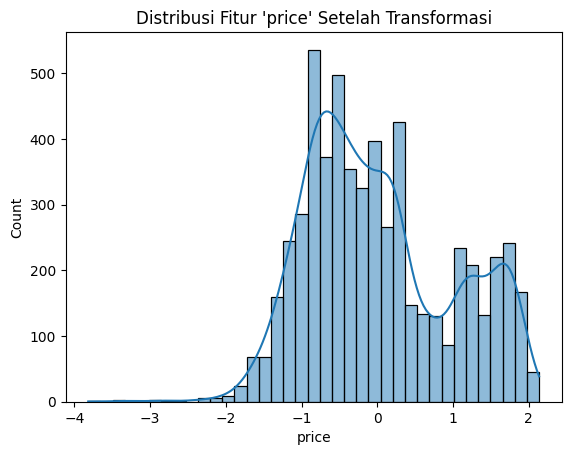

In [35]:
# Contoh untuk 1 fitur: price
sns.histplot(df['price'], kde=True)
plt.title("Distribusi Fitur 'price' Setelah Transformasi")
plt.show()

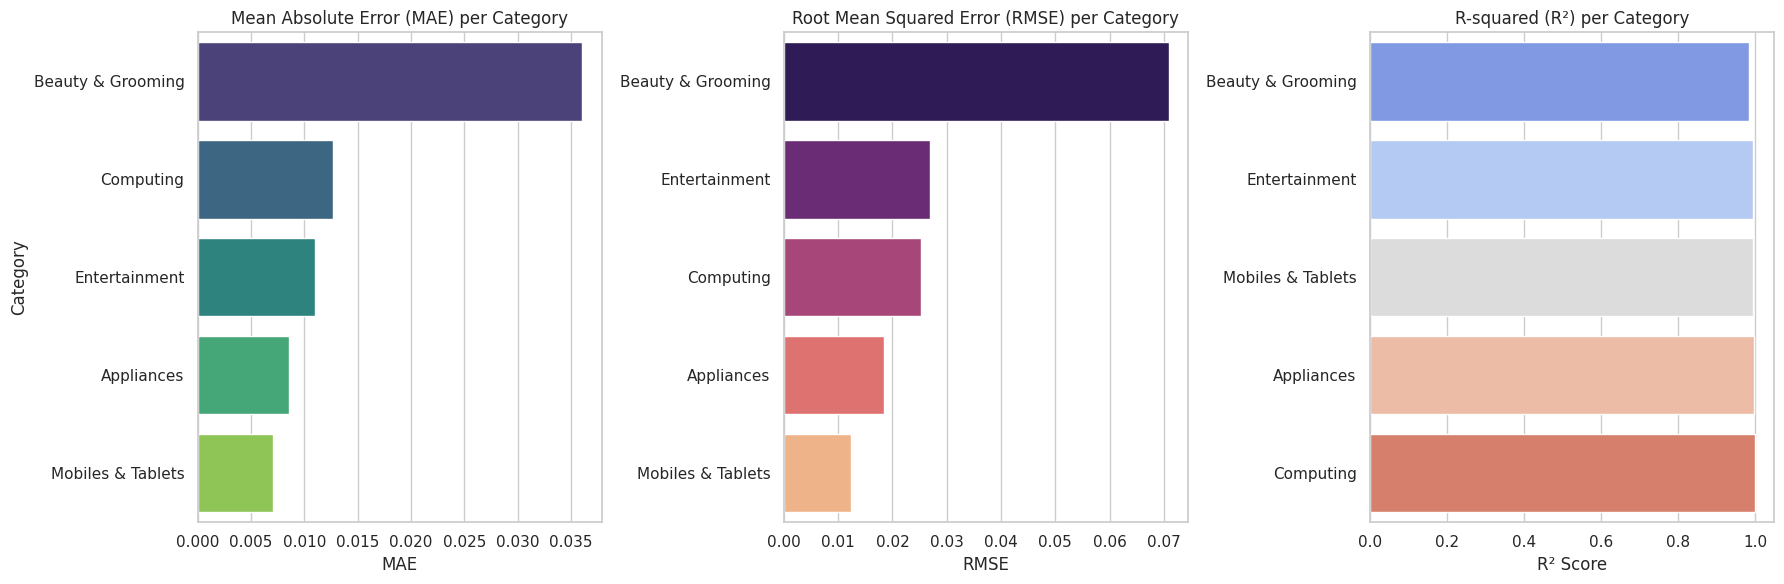

In [36]:
# Gunakan DataFrame final hasil boosting
df_viz = improved_results_df.copy()

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

# Plot 1: MAE
plt.subplot(1, 3, 1)
sns.barplot(x='MAE', y='category', data=df_viz.sort_values(by='MAE', ascending=False), palette='viridis')
plt.title('Mean Absolute Error (MAE) per Category')
plt.xlabel('MAE')
plt.ylabel('Category')

# Plot 2: RMSE
plt.subplot(1, 3, 2)
sns.barplot(x='RMSE', y='category', data=df_viz.sort_values(by='RMSE', ascending=False), palette='magma')
plt.title('Root Mean Squared Error (RMSE) per Category')
plt.xlabel('RMSE')
plt.ylabel('')

# Plot 3: R2
plt.subplot(1, 3, 3)
sns.barplot(x='R2', y='category', data=df_viz.sort_values(by='R2', ascending=True), palette='coolwarm')
plt.title('R-squared (R²) per Category')
plt.xlabel('R² Score')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [37]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Misalnya fitur dan target
features = ['log_base_price', 'log_discount', 'promo_active',
            'qty_ordered', 'is_weekend', 'customer_age_days']
target = 'log_price'

# Pastikan bersih dari NaN (bisa juga isi NaN dengan mean di sini)
df_cleaned = df[features + [target]].copy()
df_cleaned = df_cleaned.fillna(df_cleaned.mean())

X = df_cleaned[features]
y = df_cleaned[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: scaler + model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42))
])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Ekspor model ke file
joblib.dump(pipeline, 'price_prediction_model.pkl')
print("✅ Model berhasil disimpan ke 'price_prediction_model.pkl'")

✅ Model berhasil disimpan ke 'price_prediction_model.pkl'


/tmp/ipython-input-12-568752474.py:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


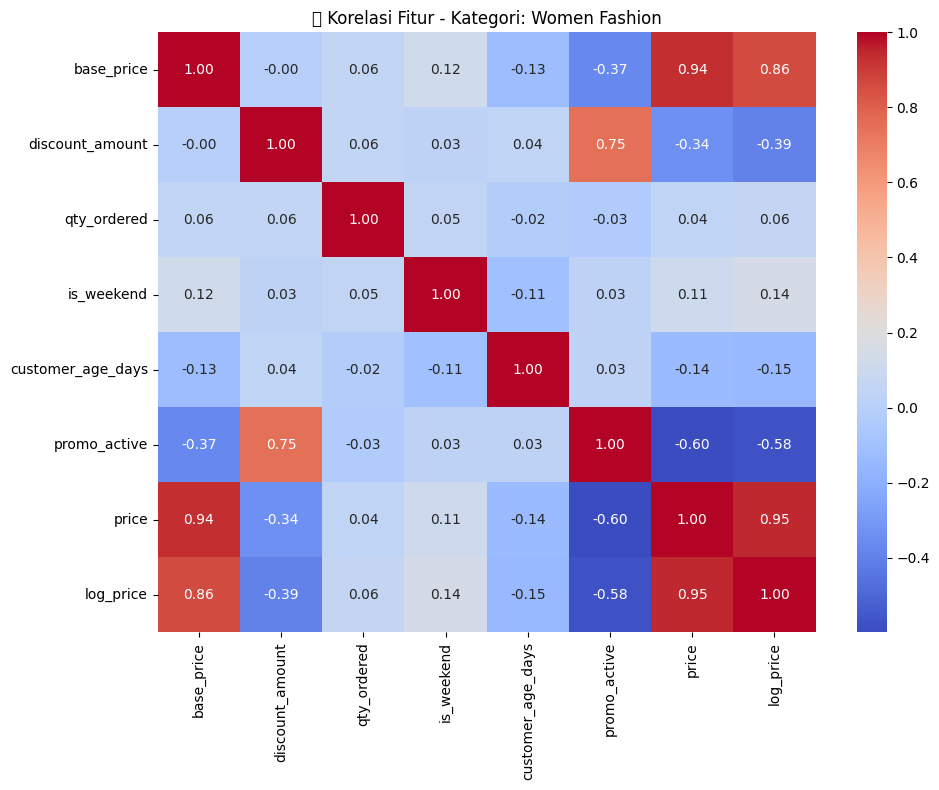

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasi
corr_matrix = df[[
    'base_price', 'discount_amount', 'qty_ordered', 'is_weekend',
    'customer_age_days', 'promo_active', 'price', 'log_price'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"🔍 Korelasi Fitur - Kategori: {category}")
plt.tight_layout()
plt.show()

In [11]:
# === 3. Prediksi dengan Data Sintetis (Tanpa Input) ===

# Pilih model acak
available_models = [f for f in os.listdir("saved_models") if f.endswith(".pkl")]
chosen_model_file = random.choice(available_models)
category_name = chosen_model_file.replace("model_", "").replace(".pkl", "")

# Load model
model = joblib.load(os.path.join("saved_models", chosen_model_file))
print(f"\n📦 Model kategori '{category_name}' dimuat.")

# Buat data input sintetis
base_price = random.randint(70000, 150000)
discount = random.randint(0, int(base_price * 0.3))
qty_ordered = random.randint(1, 10)
is_weekend = random.choice([0, 1])
customer_age = random.randint(0, 1000)
promo_active = int((discount / base_price) > 0.2)

data_input = pd.DataFrame([{
    'log_base_price': np.log1p(base_price),
    'log_discount': np.log1p(discount),
    'promo_active': promo_active,
    'qty_ordered': qty_ordered,
    'is_weekend': is_weekend,
    'customer_age_days': customer_age
}])

# Prediksi
try:
    pred_log = model.predict(data_input)
    pred_price = np.expm1(pred_log)
    print("\n🎯 Data Sintetis:")
    print(f"Base Price: {base_price} | Discount: {discount} | Qty: {qty_ordered} | Weekend: {is_weekend} | Age: {customer_age}")
    print(f"\n💡 Prediksi harga jual optimal: Rp{pred_price[0]:,.0f}")
except Exception as e:
    print(f"❌ Error saat prediksi: {e}")


📦 Model kategori 'Health & Sports' dimuat.

🎯 Data Sintetis:
Base Price: 91329 | Discount: 21879 | Qty: 3 | Weekend: 0 | Age: 848

💡 Prediksi harga jual optimal: Rp67,289
